In [2]:
%load_ext autoreload
%autoreload 2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
#import seaborn as sns
import sys
sys.path.append('../../')
from dataset import Dataset, SpikingDataset, RegSpikingDataset
from torch.utils.data.dataloader import DataLoader
from Loss import KDLoss
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
random.seed(1338)
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import copy
from pyESN import ESN
from scipy import interpolate
from gen_data import *
from tanh import tanh

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation


%load_ext autoreload

%autoreload 2

torch.__version__
# The coarse network structure is dicated by the Fashion MNIST dataset. 
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda:1')
    #device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
print(device)
tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

print("init done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cpu
init done


In [8]:
silent = True
method = 'RLS'  # RLS; INV; INV+RLS
# N_total_frame = 17
N_total_frame = 94
N_sync_frame = 4
# SNR_list = np.arange(1,20,2)
SNR_list = [1000]

# Dataset selection
folder_name = 'data/S2/'  # LOS_Near:S2, LOS_Far:S3, NLOS:S1
output_folder = 'data_outputs/S1'

if folder_name == 'data/S1/':  # NLOS
    delay = 0
    packet_num = 21
elif folder_name == 'data/S2/':  # LOS_Near
    delay = 1
    packet_num = 27 # correct
elif folder_name == 'data/S3/':  # LOS_Far
    delay = 1
    packet_num = 22 # 23c
else:
    print("Undefined Dataset")
    exit(1)
    
window_size = 2
N_reservoir = 16
debug = False

ber_record = []
dfe_ber_record = []
LS_ber_record = []
comb_ber_record = []
sta_ber_record = []
tanh_lut = tanh(
    input_bit=8,
    dx_bit=8,
    slope_fmt=(10, 10),
    intercept_fmt=(19, 19),
    max=8,
    better_lut=True,
    verbose=False,
    plot=False)

SNR = SNR_list[0]
i = 0
rc = RC(silent, method, N_total_frame, N_sync_frame, SNR, delay, window_size, i,
        N_reservoir=16,
        spectral_radius=0.2,
        sparsity=0.4,
        noise=1e-6,
        lut_activation=False,  # True,
        tanh_lut=tanh_lut,
        input_scale=25,  #40, #50, # 25,
        reservoir_input_scale = 8,  #4,  #5,
        show_wout=False,
        output_folder= output_folder,
        debug=debug,
        use_fpga= None,
        sock= None,  # usock
        addr = None) # addr

train_input, train_label, test_input, test_label = rc.run()
train_mean = np.mean(train_input)
train_std = np.std(train_input)
print(np.mean(10 * train_label), np.std(10 * train_label))
train_input = (train_input - train_mean) / train_std
test_input = (test_input - train_mean) / train_std

-0.002001994614988907 2.1725821153006826


In [6]:
noise = np.random.normal(0, np.sqrt(0.034), train_label[-1520:, :].shape)
pred_freq = rc.time_to_freq(25 * noise + 25 * train_label[-1520:, :], 19, remove_delay=False)
target_freq = rc.time_to_freq(25 * train_label[-1520:, :], 19, remove_delay=False)
rc.my_new_test(pred_freq, target_freq)

0.36951754385964913

In [4]:
print(train_input.shape)
print(test_input.shape)
print(train_label)
print(test_label.shape)

(7521, 4)
(7521, 4)
[[ 0.          0.        ]
 [ 0.36799005  0.36799005]
 [-1.05954977  0.01871674]
 ...
 [-0.11784918 -0.02450429]
 [ 0.04877258 -0.2078674 ]
 [ 0.19325261  0.22048032]]
(89, 64)


/home/studio-lab-user/.conda/envs/d2l/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


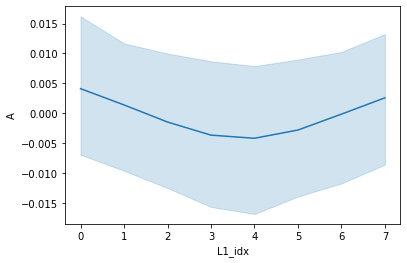

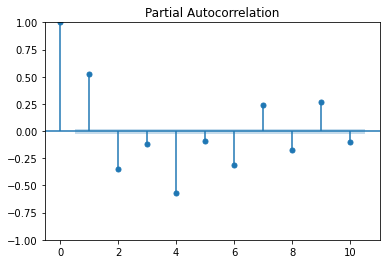

In [12]:
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

train_label_A = pd.DataFrame(train_label, columns = ['A','B'])
train_label_A['L1_idx'] = train_label_A.index % 8
sns.lineplot(data=train_label_A.loc[376:, :], x = 'L1_idx', y = 'A')
plot_pacf(train_label_A.loc[:, 'A'], lags=10);

In [13]:
mapping = train_label_A.loc[330:, :].groupby(by='L1_idx').mean().reset_index().loc[:, ['A', 'L1_idx']]
print(mapping.head(10))
print(train_label_A.head())
A = train_label_A.merge(mapping, how='left', on='L1_idx')
print(A.head(20))

          A  L1_idx
0  0.003657       0
1  0.001378       1
2 -0.001017       2
3 -0.003145       3
4 -0.003846       4
5 -0.002800       5
6 -0.000484       6
7  0.002053       7
          A         B  L1_idx
0  0.000000  0.000000       0
1  0.367990  0.367990       1
2 -1.059550  0.018717       2
3 -0.107782 -0.628198       3
4  1.142042 -0.101209       4
         A_x         B  L1_idx       A_y
0   0.000000  0.000000       0  0.003657
1   0.367990  0.367990       1  0.001378
2  -1.059550  0.018717       2 -0.001017
3  -0.107782 -0.628198       3 -0.003145
4   1.142042 -0.101209       4 -0.003846
5   0.735980  0.000000       5 -0.002800
6   1.142042 -0.101209       6 -0.000484
7  -0.107782 -0.628198       7  0.002053
8  -1.059550  0.018717       0  0.003657
9   0.367990  0.367990       1  0.001378
10  0.018717 -1.059550       2 -0.001017
11 -0.628198 -0.107782       3 -0.003145
12 -0.101209  1.142042       4 -0.003846
13  0.000000  0.735980       5 -0.002800
14 -0.101209  1.142042   

           1         2         3         4  L_0  L_1  L_2  L_3  L_4  L_5  L_6  \
0   0.004552  0.004552 -1.884776  0.275000    1    0    0    0    0    0    0   
1  -1.884776  0.275000  0.812125 -5.124172    0    1    0    0    0    0    0   
2   0.812125 -5.124172  2.434546  1.352755    0    0    1    0    0    0    0   
3   2.434546  1.352755  0.278084  5.132741    0    0    0    1    0    0    0   
4   0.278084  5.132741  0.007751  3.783358    0    0    0    0    1    0    0   
5   0.007751  3.783358  1.358923  4.861682    0    0    0    0    0    1    0   
6   1.358923  4.861682  2.700651 -2.697641    0    0    0    0    0    0    1   
7   2.700651 -2.697641 -1.350162 -4.042453    0    0    0    0    0    0    0   
8  -1.350162 -4.042453 -0.261935  2.434163    0    0    0    0    0    0    0   
9  -0.261935  2.434163  5.130832 -1.352979    1    0    0    0    0    0    0   
10  5.130832 -1.352979 -1.619047 -2.421936    0    1    0    0    0    0    0   
11 -1.619047 -2.421936 -5.12

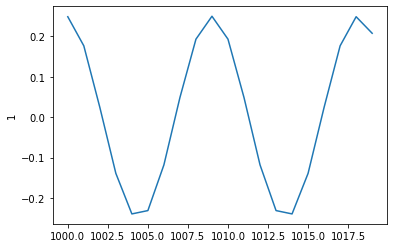

In [27]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(train_label, columns = ['1','2'])
sns.lineplot(data=df.iloc[1000:1020, :], x=df.iloc[1000:1020, :].index, y='1')

train_df = pd.DataFrame(train_input, columns = ['1','2', '3', '4'])
train_df['L1_idx'] = train_df.index % 9
train_df = pd.get_dummies(train_df, prefix=['L'], columns=['L1_idx'])
train_df['idx'] = train_df.index
print(train_df.head(20))
train_input = train_df.to_numpy()
print(train_input.shape)

test_df = pd.DataFrame(test_input, columns = ['1','2', '3', '4'])
test_df['L1_idx'] = test_df.index % 9
test_df = pd.get_dummies(test_df, prefix=['L'], columns=['L1_idx'])
test_df['idx'] = test_df.index
print(test_df.head())
test_input = test_df.to_numpy()
print(test_input.shape)

In [28]:
nb_inputs  = 8
nb_hidden  = 96
nb_outputs = 2

time_step = 1e-3
nb_steps  = 100

batch_size = 128

import scipy.io

from dataset import Dataset, RegTorchSeasonalitySpikingDataset, RegSpikingDataset, RegTorchSpikingDataset
train_data = RegTorchSeasonalitySpikingDataset(train_input, train_label, nb_inputs, nb_steps)
test_data = RegTorchSeasonalitySpikingDataset(test_input, train_label, nb_inputs, nb_steps)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
print(train_data[0][0].shape)
print(train_data[0][1].shape)
print(train_data[0][2].shape)
print(train_data[0][3].shape)

7521
(32, 100)
(1,)
(10,)
(2,)


In [31]:
class Network(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Network, self).__init__()

       # neuron_params = {
       #         'threshold'     : 0.1,
       #         'current_decay' : 1,
       #         'voltage_decay' : 0.1,
       #         'requires_grad' : True,     
       #     }
        #neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        neuron_params = {
                'threshold'     : 1.00,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        
        
        self.blocks = torch.nn.ModuleList([
                #slayer.block.cuba.Input(neuron_params),
                slayer.block.cuba.Recurrent(neuron_params, input_size, 64, weight_norm=True, delay=True),
                #slayer.block.cuba.Dense(neuron_params, 32, 64, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 64, 128, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 128, output_size, weight_norm=True),
                #slayer.block.sigma_delta.Dense(sdnn_dense_params, input_size, 64, weight_scale=2, weight_norm=True),
                #slayer.block.sigma_delta.Dense(sdnn_dense_params, 64, 128, weight_scale=2, weight_norm=True),
                #slayer.block.sigma_delta.Dense(sdnn_dense_params, 128, output_size, weight_scale=2, weight_norm=True)
                #slayer.block.cuba.Recurrent(cuba_params, 100, 50),
                #slayer.block.cuba.KWTA(cuba_params, 50, 50, num_winners=5)
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

class DNNNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16 + 1 + 10, 8)
        self.fc3 = nn.Linear(8, 2)
        #self.fc3 = nn.Linear(128, 128)
        #self.fc4 = nn.Linear(128, 2)
        self.act = nn.ReLU()

    def forward(self,x, x1, x2):
        x = x.flatten(start_dim=1)
        #x = torch.cat((x, x1), axis=1)
        x = self.fc1(x)
        x = self.act(x) 
        x = torch.cat((x, x1, x2), axis=1)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        #x = self.fc1(x)
        #x = self.act(x)
        #x = self.fc2(x)
        #x = self.act(x)
        #x = self.fc3(x)
        #x = self.act(x)
        #x = self.fc4(x)
        return x

In [32]:
net_snn = Network(nb_inputs * 4, 2).to(device)
net_dnn = DNNNetwork(2 * 100, 2).to(device)

for name, weight in net_snn.named_parameters():
    print(name, weight.shape)


blocks.0.neuron.current_decay torch.Size([1])
blocks.0.neuron.voltage_decay torch.Size([1])
blocks.0.delay.delay torch.Size([1])
blocks.0.input_synapse.weight_g torch.Size([64, 1, 1, 1, 1])
blocks.0.input_synapse.weight_v torch.Size([64, 32, 1, 1, 1])
blocks.0.recurrent_synapse.weight_g torch.Size([64, 1, 1, 1, 1])
blocks.0.recurrent_synapse.weight_v torch.Size([64, 64, 1, 1, 1])
blocks.1.neuron.current_decay torch.Size([1])
blocks.1.neuron.voltage_decay torch.Size([1])
blocks.1.delay.delay torch.Size([1])
blocks.1.synapse.weight_g torch.Size([128, 1, 1, 1, 1])
blocks.1.synapse.weight_v torch.Size([128, 64, 1, 1, 1])
blocks.2.neuron.current_decay torch.Size([1])
blocks.2.neuron.voltage_decay torch.Size([1])
blocks.2.synapse.weight_g torch.Size([2, 1, 1, 1, 1])
blocks.2.synapse.weight_v torch.Size([2, 128, 1, 1, 1])


In [33]:
def NewLoss(output, target):
    import torch
    loss = (output - target)**2 / (target + 1e-6)**2
    return torch.mean(loss)

def train(trainloader, testloader, model, DNN_model, lr=2e-3, nb_epochs=10):
    #params = [w1,w2]
    params = list(model.parameters()) + list(DNN_model.parameters())
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    
    #loss_fn = slayer.loss.SpikeTime(time_constant=2, filter_order=2, reduction='mean').to(device)
    loss_fn = torch.nn.MSELoss()
    #loss_fn = torch.nn.SmoothL1Loss()
    loss_hist = []
    DNN_model.train()
    
    
    for e in range(nb_epochs):
        print(e)
        local_loss = []
        for x_local, x1_local, x2_local, y_local in trainloader:
            x_local = x_local.float().to(device)
            x1_local = x1_local.float().to(device)
            x2_local = x2_local.float().to(device)
            y_local = y_local.float().to(device)
    
            #output = model(x_local)
            #output = output.flatten(start_dim=1)
            optimizer.zero_grad()
            output = model(x_local)
            output = DNN_model(output, x1_local, x2_local)
            loss_val = loss_fn(output, y_local) 
            loss_val.backward()
            #print("AAAA: ", DNN_model.fc2.weight)
            #print("BBBB: ", DNN_model.fc1.weight.grad)
            optimizer.step()
            local_loss.append(loss_val.item())
            
        
        #if e % 1 == 30 and e != 0:
        #    print("Training accuracy: %.3f"%(compute_ber(trainloader, net, "train")))
        #    print("Test accuracy: %.3f"%(compute_ber(testloader, net, name)))
        scheduler.step()
        mean_loss = np.mean(local_loss)
        print(mean_loss)
        #print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        

In [ ]:
train(train_loader, train_loader, net_snn, net_dnn, lr=1e-3, nb_epochs=100)

0
19086.22795234292
1
56.10892581131499
2
5.417029312101461
3
2.890116269305601
4
1.4263144297114874
5
0.6770637399059231
6
0.3195172616485822
7
0.16662079209493377
8
0.10983113344695608
9
0.09181043051056943
10
0.08659140835121526
11
0.0848815236556328
12
0.08445059002961143
13
0.08336226705272319
14
0.08262210901258356
15
0.08207596150242676
16
0.08197126373396081
17
0.08166809487393346
18
0.0823753335339538
19
0.08039930298671884
20
0.07965992706812035
21
0.0801417845285545
22
0.07838366610013832
23


In [28]:
net_snn.export_hdf5('./net_snn.net')
torch.save(net_dnn.state_dict(), './net_dnn.pth')

In [24]:
all_output = []
inputs = []
labels = []
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=False)
for input, input1, input2, target in test_loader:
    inputs.append(input)
    labels.append(target)
    target = torch.tensor(target).float()
    input = torch.tensor(input).float()
    input1 = torch.tensor(input1).float()
    input2 = torch.tensor(input2).float()
    
    output = net_snn(input)
    output = net_dnn(output, input1, input2).cpu().detach().numpy()
    all_output.append(output)
    
all_output = np.concatenate(all_output, axis=0)
ber = rc.my_test(all_output)
print(ber)

/tmp/ipykernel_101/168678358.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).float()
/tmp/ipykernel_101/168678358.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input).float()
/tmp/ipykernel_101/168678358.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input1 = torch.tensor(input1).float()
/tmp/ipykernel_101/168678358.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

0.18176498127340823


In [11]:
A1 = 8 * torch.ones((128, 8))
A2 = torch.ones((128, 1))
print(A1 + A2)

tensor([[9., 9., 9.,  ..., 9., 9., 9.],
        [9., 9., 9.,  ..., 9., 9., 9.],
        [9., 9., 9.,  ..., 9., 9., 9.],
        ...,
        [9., 9., 9.,  ..., 9., 9., 9.],
        [9., 9., 9.,  ..., 9., 9., 9.],
        [9., 9., 9.,  ..., 9., 9., 9.]])
